In [1]:
%tensorflow_version 2.x  # Colab only.
import tensorflow as tf
print(tf.__version__)

from os.path import join  
from google.colab import drive
ROOT = "/content/drive"  
drive.mount(ROOT) 
print("hello")
PROJECT_PATH = "/content/drive/My Drive/projects/MuseumBrickWallRecog/MuseumBrickWallRecog"
%cd {PROJECT_PATH}

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.2.0-rc2
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
hello
/content/drive/My Drive/projects/MuseumBrickWallRecog/MuseumBrickWallRecog


In [0]:
import glob
filelist = [f.split('/')[1] for f in glob.glob("blocks/*.png", recursive=False)]
filelist

In [0]:
np.arange(0,10)

In [7]:
import numpy as np
shuffled = np.random.permutation(np.arange(0,len(filelist)))
newlist = [filelist[i] for i in shuffled[:20]]
newlist

['chu_019.png',
 'murm_014.png',
 'bay_003.png',
 'fox_002.png',
 'dock_004.png',
 'dock_013.png',
 'bay_018.png',
 'dock_019.png',
 'chu_013.png',
 'dock_009.png',
 'bay_012.png',
 'alesha_013.png',
 'chu_010.png',
 'murm_001.png',
 'fox_019.png',
 'dock_011.png',
 'fox_015.png',
 'bay_008.png',
 'bay_019.png',
 'murm_012.png']

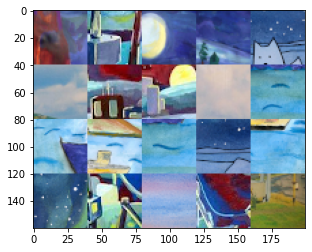

In [11]:
from PIL import Image
import matplotlib.pyplot as plt

#https://note.nkmk.me/en/python-pillow-concat-images/
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

def get_concat_v_series(imNamesList):
    im0 = Image.open(PROJECT_PATH +"/blocks/"+imNamesList.pop(0))
    for imName in imNamesList:
        im = Image.open(PROJECT_PATH +"/blocks/"+imName)
        im0 = get_concat_v(im0, im)
    return im0

def get_concat_h_series(imList):
    im0 = imList.pop(0)
    for im in imList:        
        im0 = get_concat_h(im0, im)
    return im0

def create_image(imNamesList,rotationValsList):    
    imCol0 = get_concat_v_series(imNamesList[:4])
    imCol1 = get_concat_v_series(imNamesList[4:8])
    imCol2 = get_concat_v_series(imNamesList[8:12])
    imCol3 = get_concat_v_series(imNamesList[12:16])
    imCol4 = get_concat_v_series(imNamesList[16:20])
    return get_concat_h_series([imCol0,imCol1,imCol2,imCol3,imCol4])


plt.imshow(create_image(newlist))
#get_concat_h(im1, im1).save('data/dst/pillow_concat_h.jpg')
#get_concat_v(im1, im1).save('data/dst/pillow_concat_v.jpg')


In [0]:
import os
from PIL import Image
Image.MAX_IMAGE_PIXELS = None # to avoid image size warning
savedir = PROJECT_PATH +"/parts"

start_pos = start_x, start_y = (0, 0)
cropped_image_size = w, h = (40, 40)

for file in filelist:
    img = Image.open(PROJECT_PATH +"/data/"+file)
    width, height = img.size
    frame_num = 1
    for col_i in range(0, width, w):
        for row_i in range(0, height, h):
            crop = img.crop((col_i, row_i, col_i + w, row_i + h))            
            name = os.path.splitext(file)[0]
            save_to= os.path.join(savedir, name+"_{:03}.png")
            crop.save(save_to.format(frame_num))
            frame_num += 1

In [0]:
!ls "parts"

In [0]:
%cd parts
!ls

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
im = Image.open("dock_005.png").rotate(0)
plt.imshow(im)

In [0]:
#https://note.nkmk.me/en/python-pillow-concat-images/

In [0]:
POKE_DIM = 200
ch = np.array(ch)
bb = np.array(bb)
sq = np.array(sq)
CH_H, CH_W, CH_C = ch.shape
BB_H, BB_W, BB_C = bb.shape
SQ_H, SQ_W, SQ_C = sq.shape

# useful store these in an array
poke_data = [
  [ch, CH_H, CH_W, CH_C],
  [bb, BB_H, BB_W, BB_C],
  [sq, SQ_H, SQ_W, SQ_C],
]
class_names = ['Charmander', 'Bulbasaur', 'Squirtle']

In [0]:
def custom_loss(y_true, y_pred):
  # target is a 8-tuple
  # (row, col, depth, width, class1, class2, class3, object_appeared)

  bce = binary_crossentropy(y_true[:, :4], y_pred[:, :4]) # location
  cce = categorical_crossentropy(y_true[:, 4:7], y_pred[:, 4:7]) # object class
  bce2 = binary_crossentropy(y_true[:, -1], y_pred[:, -1]) # object appeared

  return bce * y_true[:, -1] + cce * y_true[:, -1] + 0.5 * bce2

In [0]:
def make_model():
  vgg = tf.keras.applications.VGG16(
    input_shape=[POKE_DIM, POKE_DIM, 3],
    include_top=False,
    weights='imagenet')
  x = Flatten()(vgg.output)
  x1 = Dense(4, activation='sigmoid')(x) # location
  x2 = Dense(3, activation='softmax')(x) # object class
  x3 = Dense(1, activation='sigmoid')(x) # object appeared
  x = Concatenate()([x1, x2, x3])
  model = Model(vgg.input, x)
#   model.compile(loss=custom_loss, optimizer=SGD(learning_rate=0.01, momentum=0.9))
  model.compile(loss=custom_loss, optimizer=Adam(lr=0.0001))
  return model

In [0]:
from glob import glob
backgrounds = []

background_files = glob('backgrounds/*.jpg')
for f in background_files:
  # Note: they may not all be the same size
  bg = np.array(image.load_img(f))
  backgrounds.append(bg)

In [0]:
plt.imshow(backgrounds[3])

In [0]:
def pokemon_generator_multiclass(batch_size=64):
  # generate image and targets
  while True:
    # Each epoch will have 50 batches. Why? No reason
    for _ in range(50):
      X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
      Y = np.zeros((batch_size, 8))
      
      for i in range(batch_size):
        # select a random background
        bg_idx = np.random.choice(len(backgrounds))
        bg = backgrounds[bg_idx]
        bg_h, bg_w, _ = bg.shape
        rnd_h = np.random.randint(bg_h - POKE_DIM)
        rnd_w = np.random.randint(bg_w - POKE_DIM)
        X[i] = bg[rnd_h:rnd_h+POKE_DIM,rnd_w:rnd_w+POKE_DIM].copy()
        
        # 25% no object, 25% + 25% + 25% for the 3 classes
        appear = (np.random.random() < 0.75)
        if appear:
          
          # choose a pokemon
          pk_idx = np.random.randint(3)
          pk, h, w, _ = poke_data[pk_idx]

          # resize object - make it bigger or smaller
          scale = 0.5 + np.random.random()
          new_height = int(h * scale)
          new_width = int(w * scale)
          obj = resize(
              pk,
              (new_height, new_width),
              preserve_range=True).astype(np.uint8) # keep it from 0..255

          # maybe flip
          if np.random.random() < 0.5:
            obj = np.fliplr(obj)

          # choose a random location to store the object
          row0 = np.random.randint(POKE_DIM - new_height)
          col0 = np.random.randint(POKE_DIM - new_width)
          row1 = row0 + new_height
          col1 = col0 + new_width

          # can't 'just' assign obj to a slice of X
          # since the transparent parts will be black (0)
          mask = (obj[:,:,3] == 0) # find where the pokemon is 0
          bg_slice = X[i,row0:row1,col0:col1,:] # where we want to place `obj`
          bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
          bg_slice += obj[:,:,:3] # "add" the pokemon to the slice
          X[i,row0:row1,col0:col1,:] = bg_slice # put the slice back
        
          # make targets

          # location
          Y[i,0] = row0/POKE_DIM
          Y[i,1] = col0/POKE_DIM
          Y[i,2] = (row1 - row0)/POKE_DIM
          Y[i,3] = (col1 - col0)/POKE_DIM

          # class
          Y[i,4 + pk_idx] = 1
        
        # did the pokemon appear?
        Y[i,7] = appear
      
      yield X / 255., Y

In [0]:
xx = None
yy = None
for x, y in pokemon_generator_multiclass():
  xx, yy = x, y
  break

In [0]:
n = yy.shape[0]
idx = np.random.randint(n)
plt.imshow(xx[idx]);
print(yy[idx])
print("percent no obj:", (yy[:,7] == 0).sum() / n)
print("percent charmander:", yy[:,4].sum() / n)
print("percent bulbasaur:", yy[:,5].sum() / n)
print("percent squirtle:", yy[:,6].sum() / n)

In [0]:
model = make_model()
model.fit_generator(
    pokemon_generator_multiclass(),
    steps_per_epoch=50,
    epochs=5,
)

In [0]:
# Make predictions
def pokemon_prediction_multiclass():
  # select a random background
  bg_idx = np.random.choice(len(backgrounds))
  bg = backgrounds[bg_idx]
  bg_h, bg_w, _ = bg.shape
  rnd_h = np.random.randint(bg_h - POKE_DIM)
  rnd_w = np.random.randint(bg_w - POKE_DIM)
  x = bg[rnd_h:rnd_h+POKE_DIM,rnd_w:rnd_w+POKE_DIM].copy()
  
  appear = (np.random.random() < 0.75)
  if appear:

    # choose a pokemon
    pk_idx = np.random.randint(3)
    pk, h, w, _ = poke_data[pk_idx]
        
    # resize charmander - make it bigger or smaller
    scale = 0.5 + np.random.random()
    new_height = int(h * scale)
    new_width = int(w * scale)
    obj = resize(
        pk,
        (new_height, new_width),
        preserve_range=True).astype(np.uint8) # keep it from 0..255

    # maybe flip
    if np.random.random() < 0.5:
      obj = np.fliplr(obj)

    # choose a random location to store the object
    row0 = np.random.randint(POKE_DIM - new_height)
    col0 = np.random.randint(POKE_DIM - new_width)
    row1 = row0 + new_height
    col1 = col0 + new_width

    # can't 'just' assign obj to a slice of X
    # since the transparent parts will be black (0)
    mask = (obj[:,:,3] == 0) # find where the pokemon is 0
    bg_slice = x[row0:row1,col0:col1,:] # where we want to place `obj`
    bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
    bg_slice += obj[:,:,:3] # "add" the pokemon to the slice
    x[row0:row1,col0:col1,:] = bg_slice # put the slice back
    actual_class = class_names[pk_idx]
    print("true:", row0, col0, row1, col1, actual_class)
  
  # Predict
  X = np.expand_dims(x, 0) / 255.
  p = model.predict(X)[0]
  
  # Plot
  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  
  # Draw the box
  if p[-1] > 0.5:
    row0 = int(p[0]*POKE_DIM)
    col0 = int(p[1]*POKE_DIM)
    row1 = int(row0 + p[2]*POKE_DIM)
    col1 = int(col0 + p[3]*POKE_DIM)
    class_pred_idx = np.argmax(p[4:7])
    class_pred = class_names[class_pred_idx]
    print("pred:", row0, col0, row1, col1, class_pred)
    rect = Rectangle(
        (p[1]*POKE_DIM, p[0]*POKE_DIM),
        p[3]*POKE_DIM, p[2]*POKE_DIM,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
  else:
    print("pred: no object")
  plt.show()

In [0]:
pokemon_prediction_multiclass()